# Определение перспективного тарифа для телеком-компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

* Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

* Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Примечание:

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

1. Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана
2. Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок
3. Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение
4. Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя
5. Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Откройте файл с данными и изучите общую информацию

Из инструкции по выполнению проекта

1. Путь к файлам:
* /datasets/calls.csv
* /datasets/internet.csv
* /datasets/messages.csv
* /datasets/tariffs.csv
* /datasets/users.csv

In [ ]:
import pandas as pd
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np

Подключение необходимых библиотек

In [ ]:
data_users = pd.read_csv('/datasets/users.csv')
data_users.info(), data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


(None,
    user_id  age churn_date         city first_name  last_name    reg_date  \
 0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
 1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
 2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
 3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
 4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   
 
   tariff  
 0  ultra  
 1  smart  
 2  smart  
 3  ultra  
 4  ultra  )

Общая информация о таблице users

In [ ]:
data_users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
480,1480,29,2018-09-26,Новокузнецк,Гелена,Емельянова,2018-02-14,smart
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
267,1267,63,NaN,Екатеринбург,Яна,Седова,2018-08-05,smart
119,1119,53,NaN,Петрозаводск,Олег,Сухарев,2018-04-22,smart
381,1381,64,NaN,Москва,Тамара,Серебрякова,2018-01-13,ultra


5 случайных строк таблицы users

* Категориальная переменная: [user_id, churn_date, city, first_name, last_name, reg_date, tariff]
* Количественная переменная: [age]

user_id отражает, сколько всего было зарегистрированно пользователей. Новый пользователь получает номер n+1 от предыдущего.

Столбец churn_date имеет пропуски. Это было описано в задании.

In [ ]:
data_calls = pd.read_csv('/datasets/calls.csv')
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Общая информация о таблице calls

In [ ]:
data_calls.sample(5)

,id,call_date,duration,user_id
4143,1011_237,2018-09-07,9.84,1011
13204,1034_143,2018-09-08,20.87,1034
28911,1072_237,2018-10-03,1.87,1072
53931,1135_224,2018-11-25,14.20,1135
126942,1325_323,2018-07-16,9.64,1325


5 случайных строк таблицы calls

* Категориальная переменная: id, call_date, user_id.
* Количественная переменная: duration.

In [ ]:
data_messages = pd.read_csv('/datasets/messages.csv')
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Общая информация о таблице messages

In [ ]:
data_messages.sample(5)

,id,message_date,user_id
107434,1433_41,2018-11-08,1433
68604,1293_19,2018-10-20,1293
41871,1178_94,2018-06-20,1178
116967,1475_171,2018-07-25,1475
38597,1166_423,2018-08-19,1166


5 случайных строк таблицы messages

* Категориальная переменная: id, message_date, user_id.

In [ ]:
data_internet = pd.read_csv('/datasets/internet.csv')
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Общая информация о таблице internet

In [ ]:
data_internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
113125,113125,1382_118,780.49,2018-12-06,1382
58987,58987,1198_188,396.81,2018-12-29,1198
36995,36995,1127_345,661.82,2018-08-13,1127
112342,112342,1380_471,460.80,2018-08-22,1380
83791,83791,1284_145,866.94,2018-04-19,1284


5 случайных строк таблицы internet

* Категориальная переменная: id, session_date, user_id.
* Количественная переменная: mb_used.

Пропуски в столбце mb_used говорят об потере данных.

In [ ]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Общая информация о таблице tariffs

In [ ]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


все строки таблицы tariffs

* Категориальная переменная: tariff_name.
* Количественная переменная: messages_included, mb_per_month_included, minutes_included, rub_monthly_fee, rub_per_gb, rub_per_message, rub_per_minute.

### Вывод

У следующих столбцов необходимо изменить тип:
1. в таблице users
* churn_date на datetime
* reg_date на datetime
2. в таблице messages
* message_date на datetime
3. в таблице internet
* session_date на datetime
4. calls
* call_date на datetime

У столбца churn_date из описания данных, есть пропуски, которые нужно изменить на явное значение.

## Подготовьте данные

In [ ]:
def fillna_churn_date(row):
    if pd.isnull(row['churn_date']):
        MAX_YEARS = 100
        delta = MAX_YEARS - row['age'] 
        date = str(2021 + delta)+'-12-16'
        row['churn_date'] = pd.to_datetime(date,format = '%Y-%m-%d')
    return row
data_users = data_users.apply(fillna_churn_date, axis = 1)

Пропуски в таблице data_users столбец churn_date. В основном люди не живут дольше 100 лет. Прибавим к текущей дате разницу между 100 и возрастом абонента и заполним этим значением пропуски

In [ ]:
data_calls.query('duration == 0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


39613 строк звонков с нулевой длительностью. За ноль обозначены несостоявшиеся звонки. Нулевая их длительность вызвана прерыванием связи или случаями, когда у другого абонента было "занято" и поэтому происходил моментальный сброс вызова после дозвона. Они не расходуют лимиты минут и вообще не принимают участия в формировании конечной выручки.

In [ ]:
data_internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


19598 строк с нулевой длительностью. За ноль обозначены сессии, в случаях, когда подключение было включено, но операций не происходило или когда появляется и сразу пропадает подключение к сети. Такие сессии не расходуют лимиты и не принимают участия в формировании конечной выручки.

In [ ]:
data_calls['duration']  = np.ceil(data_calls['duration']).astype(int)

Округляем звонки вверх.

In [ ]:
columns_to_datetime = {"reg_date":data_users,
                       "message_date":data_messages,
                       "session_date":data_internet,
                       "call_date":data_calls}

for column, frame in columns_to_datetime.items():
    frame[column] = pd.to_datetime(frame[column],format = '%Y-%m-%d')

Изменение типов столбцов reg_date, message_date, session_date, call_date к типу datetime

In [ ]:
data_calls['month'] = data_calls["call_date"].dt.month
data_messages['month'] = data_messages["message_date"].dt.month
data_internet['month'] = data_internet['session_date'].dt.month

Создадим столбцы хранящие в себе значение месяцев, когда произошло событие

In [ ]:
data_calls['duration'] = data_calls['duration'].replace(0, np.NaN)
data_calls = data_calls.dropna()
data_internet['mb_used'] = data_internet['mb_used'].replace(0, np.NaN)
data_internet = data_internet.dropna()

Нулевые значения меняем на нан и убираем все строки с нан.

In [ ]:
statistic_frame = pd.DataFrame(columns = ['user_id',
                                    "month",
                                    "count_calls",
                                    'calls_total_duration',
                                    'count_messages',
                                    'total_mb_used'
                                   ])
for idx in data_users['user_id']:
    for month_x in range(1,13):
        if ((month_x in data_calls.query('user_id == @idx')['month'].to_numpy()) or
            (month_x in data_messages.query('user_id == @idx')['month'].to_numpy())):
            
            count_calls = data_calls.query('user_id == @idx and month == @month_x').shape[0]
            total_duration_calls = data_calls.query('user_id == @idx and month == @month_x')['duration'].sum()
            count_messages = data_messages.query('user_id == @idx and month == @month_x').shape[0]
            total_used = data_internet.query('user_id == @idx and month == @month_x')['mb_used'].sum()
            
            statistic_frame = statistic_frame.append({'user_id':idx,
                               'month':month_x,             
                               "count_calls":count_calls,
                               'calls_total_duration':total_duration_calls,
                               'count_messages':count_messages,
                               'total_mb_used':total_used             
                                           }, ignore_index=True)
statistic_frame['user_id'] = statistic_frame['user_id'].astype('int')

Для дальнейшего анализа подготавливаем необходимые данные

In [ ]:
statistic_frame = statistic_frame.merge(data_users[['user_id','tariff']], on = 'user_id')
statistic_frame = statistic_frame.merge(data_users[['user_id','city']], on = 'user_id')
statistic_frame

,user_id,month,count_calls,calls_total_duration,count_messages,total_mb_used,tariff,city
0,1000,5.0,17.0,159.0,22.0,2253.49,ultra,Краснодар
1,1000,6.0,28.0,172.0,60.0,23233.77,ultra,Краснодар
2,1000,7.0,41.0,340.0,75.0,14003.64,ultra,Краснодар
3,1000,8.0,42.0,408.0,81.0,14055.93,ultra,Краснодар
4,1000,9.0,46.0,466.0,57.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3207,1498,10.0,30.0,247.0,42.0,20579.36,smart,Владикавказ
3208,1499,9.0,8.0,70.0,11.0,1845.75,smart,Пермь
3209,1499,10.0,44.0,449.0,48.0,17788.51,smart,Пермь
3210,1499,11.0,62.0,612.0,59.0,17963.31,smart,Пермь


В таблицу для анализа данных добавили значение тарифа и города

In [ ]:
# Функция рассчитывающая доход копании с конкретного абонента
def get_income(row):
    def get_extra(dict_of_param):
        # Функция рассчитывающая минуты, потраченные абонентом сверх базового пакета
        local_extra_min = 0
        local_extra_sms = 0
        local_extra_gb = 0
        if row['calls_total_duration'] > dict_of_param['calls_total_duration']: 
            local_extra_min = row['calls_total_duration'] - dict_of_param['calls_total_duration']
        if row['count_messages'] > dict_of_param['count_messages']:
            local_extra_sms = row['count_messages'] - dict_of_param['count_messages']
        if row['total_mb_used'] > dict_of_param['total_mb_used']:
            local_extra_gb = np.ceil((row['total_mb_used'] - dict_of_param['total_mb_used'])/1024)
            # добавлено округление вверх
        return local_extra_min, local_extra_sms, local_extra_gb   
    
    ultra_param = {
        'calls_total_duration':3000,
        'count_messages': 1000,
        'total_mb_used': 30 * 1024
    }
    smart_param = {
        'calls_total_duration':500,
        'count_messages': 50,
        'total_mb_used': 15 * 1024
    }
            
    if row['tariff'] == 'ultra':
        income = 1950
        extra_min, extra_sms, extra_gb = get_extra(ultra_param)
        income += extra_min + extra_sms + extra_gb * 150     
    elif row['tariff'] == 'smart':
        income = 550
        extra_min, extra_sms, extra_gb = get_extra(smart_param)
        income += 3 * extra_min + 3* extra_sms + extra_gb * 200 
    return income

Функция для расчета дохода компании с абонента

In [ ]:
statistic_frame['income'] = statistic_frame.apply(get_income, axis = 1)
statistic_frame

,user_id,month,count_calls,calls_total_duration,count_messages,total_mb_used,tariff,city,income
0,1000,5.0,17.0,159.0,22.0,2253.49,ultra,Краснодар,1950.0
1,1000,6.0,28.0,172.0,60.0,23233.77,ultra,Краснодар,1950.0
2,1000,7.0,41.0,340.0,75.0,14003.64,ultra,Краснодар,1950.0
3,1000,8.0,42.0,408.0,81.0,14055.93,ultra,Краснодар,1950.0
4,1000,9.0,46.0,466.0,57.0,14568.91,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3207,1498,10.0,30.0,247.0,42.0,20579.36,smart,Владикавказ,1750.0
3208,1499,9.0,8.0,70.0,11.0,1845.75,smart,Пермь,550.0
3209,1499,10.0,44.0,449.0,48.0,17788.51,smart,Пермь,1150.0
3210,1499,11.0,62.0,612.0,59.0,17963.31,smart,Пермь,1513.0


Добавли столбец с доходом копании с конкретного абонента

### Вывод

Убрали пропуски и изменили тип данных.
Подготовили дополнительные столбцы для анализа.

Нулевые значения в полях: длительность звонка или объем интернет сессии не повлияют на наше исследование. Так как данные значения влияют только на количество звонков, которые мы не исследуем, то дополнительно исключать их из выборки или изменять их значение не имеет смысла

## Проанализируйте данные

In [ ]:
statistic_frame.pivot_table(index = 'tariff', values = ['calls_total_duration',
                                                        'count_messages',
                                                        'total_mb_used','income'], aggfunc = ["median",
                                                                                     "mean",
                                                                                     'var',
                                                                                     'std'])

median                                       \
       calls_total_duration count_messages  income total_mb_used   
tariff                                                             
smart                 422.0           28.0  1023.0      16506.84   
ultra                 519.0           38.0  1950.0      19315.85   

                       mean                                            \
       calls_total_duration count_messages       income total_mb_used   
tariff                                                                  
smart            417.934948      33.384029  1289.973531  16208.386990   
ultra            527.694812      49.463886  2070.396745  19506.900142   

                        var                                              \
       calls_total_duration count_messages         income total_mb_used   
tariff                                                                    
smart          36219.315784     796.812958  669785.708006  3.446250e+07   
ultra         100513.098211    2284.947523  141775.504348  1.012427e+08   

                        std                                           
       calls_total_duration count_messages      income total_mb_used  
tariff                                                                
smart            190.313730      28.227876  818.404367   5870.476681  
ultra            317.038008      47.801125  376.530881  10061.942990

Вывод сводной таблицы по тарифам.

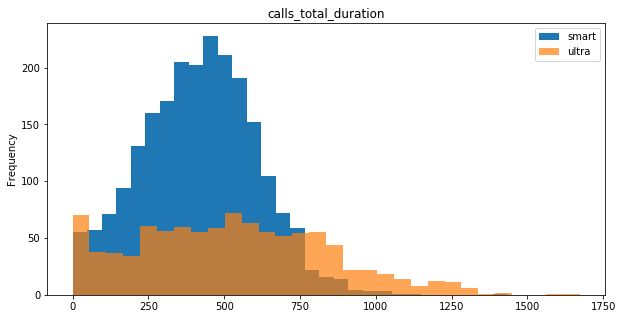

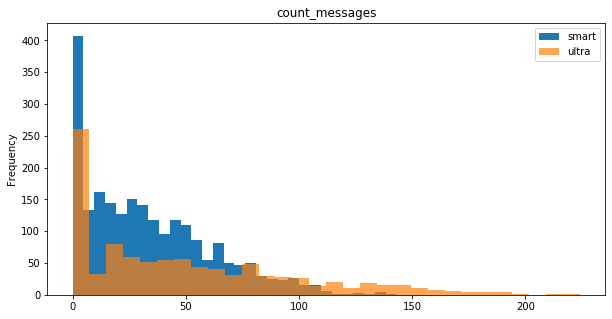

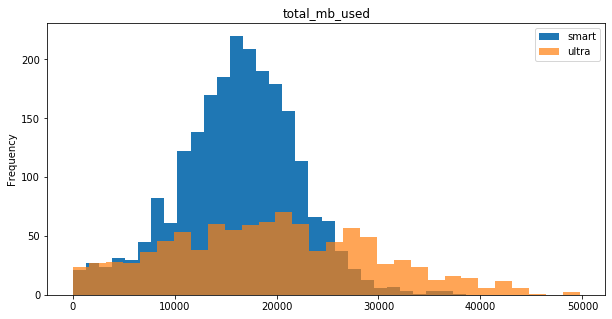

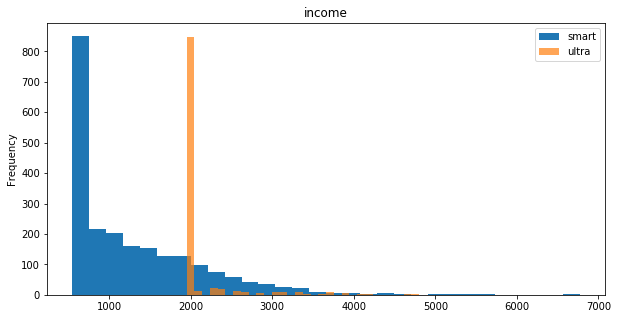

In [ ]:
list_of_columns=['calls_total_duration','count_messages','total_mb_used','income']
tariffs = ['ultra','smart']
for column in list_of_columns:
        statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart'][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            label = 'smart', figsize = (10,5)
                                                                           )
        statistic_frame.loc[statistic_frame.loc[:,'tariff'] == "ultra"][column].plot(
                                                                            kind = 'hist',
                                                                            bins = 30,
                                                                            alpha =0.7,
                                                                            label = 'ultra',figsize = (10,5)
                                                                           )
        plt.title(column)
        plt.legend()
        plt.show()

Вывод графиков для анализа

### Вывод
На гистограммах можно заметить, что у тарифа ultra гистограммы скошены вправо, а в тарифе smart гистограммы скошены влево. Это так же подтверждают данные медианы и среднего, приведенные в сводной таблице. Кроме этого можно заметить, что пользователи тарифа ultra не тратят весь базовый пакет минут и количества смс, в отличие от тарифа smart

## Проверьте гипотезы

### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [ ]:
alpha = 0.05
income_ultra = statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'ultra']['income']
income_smart = statistic_frame.loc[statistic_frame.loc[:,'tariff'] == 'smart']['income']
result = st.ttest_ind(income_smart,income_ultra) 
prob = result.pvalue
print("p-значение:{}".format(prob))
if prob < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось нулевую гипотезу")

p-значение:2.2931300479841166e-160
Отвергаем нулевую гипотезу


Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

Альтернативная гипотеза : средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

#### Вывод

проверка показала, что мы отвергаем гипотезу о том, что среднее значение дохода абонентов 2 тарифов равны, следовательно подтверждаем гипотезу средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [ ]:
city_moscow = statistic_frame.loc[statistic_frame.loc[:,'city'] == 'Москва']['income']
city_other = statistic_frame.loc[statistic_frame.loc[:,'city'] != 'Москва']['income']
result_city = st.ttest_ind(city_moscow,city_other,equal_var=False) 
prob_city = result_city.pvalue
print("p-значение:{}".format(prob_city))
if prob_city < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:0.5357205599549668
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [ ]:
print('Дисперсия первой совокупности:',np.var(city_moscow))
print('Дисперсия второй совокупности:',np.var(city_other))

Дисперсия первой совокупности: 565369.4070841172
Дисперсия второй совокупности: 654068.1632453543


дисперсия выборок

#### Вывод

Вероятность нулевой гипотезы очень велика, поэтому мы не можем ее отбростить и сказать, что вырочка абонентов из Москвы достаточно сильно откличается от пользователей других городов

## Вывод

Из описание проекта, нам нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Тариф ultra лучше, несмотря на то, что его абоненты не покупают дополнительные минуты и смс, в отличие от абонентов тарифа smart. Так же можно заметить, что медианное и среднее значение дохода у абонентов тарифа ultra выше.

При проверках двух гипотез. Опровергнули гипотезы о том, что средняя выручка пользователей разных тарифов равна и с большой вероятностью средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

В процессе анализа выяснилось, что в среднем разница медианных и среднеарифметических значений дохода с разных тарифов отличается ~1000 в пользу тарифа ultra.